In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from skimage.io import imread, imshow, imread_collection, concatenate_images
import cv2
from tqdm import tqdm
import copy
import logging
import os
from pathlib import Path
import const
from numba import double
from numba.decorators import jit

ROOT_DIR = Path().resolve()
ROOT_DIR = ROOT_DIR / const.sample1
HORIZONTAL_SPLIT = const.HORIZONTAL_SPLIT
VERTICAL_SPLIT = const.VERTICAL_SPLIT
margin = const.margin
if ROOT_DIR == Path().resolve() / const.sample1:
    SCALE = 15/339
elif ROOT_DIR == Path().resolve() / const.sample2:
    SCALE = 35/371
    # 35/339
else: # '3'
    SCALE = 35/310
    # 35/298

size_min = const.size_min
size_max = const.size_max
size_min *= (1/SCALE)*(1/SCALE)
size_max *= (1/SCALE)*(1/SCALE)

if ROOT_DIR == Path().resolve() / const.sample1:
    interval_y = 88
    interval_x = 76
elif ROOT_DIR == Path().resolve() / const.sample2:
    interval_y = 70
    interval_x = 87
elif ROOT_DIR == Path().resolve() / const.sample3:
    interval_y = 75
    interval_x = 74

def s(img, title=''):
    """
    Show image with title.
    :param img: input image
    :param img: title should be shown(default is empty)
    """
    plt.figure(figsize=(6,6))
    plt.title(title + str(img.shape))
    imshow(img)
    plt.show()
    
def inputPicture(pic_name):
    """
    Input image.
    :param pic_name: load picture
    """
    path = ROOT_DIR / pic_name
    pic_color = cv2.imread(str(path), cv2.IMREAD_COLOR)
    pic_color = cv2.cvtColor(pic_color, cv2.COLOR_BGR2RGB)
    return pic_color

def pin_drawing(pic):
    """
    Make margin on cercumference, draw a pin on every intersection (HORIZONTAL)*(VERTICAL)
    of grid in 0% strain
    :param pic: image at which pins are drawn
    :return: interval of x and y axis
    """
    interval_y_= int((pic.shape[0] - 2*margin)/(HORIZONTAL_SPLIT - 1))
    interval_x_ = int((pic.shape[1] - 2*margin)/(VERTICAL_SPLIT - 1))

    for i in range(VERTICAL_SPLIT):
        for j in range(HORIZONTAL_SPLIT):
            cv2.rectangle(pic, (interval_x_*j + margin, interval_y_*i + margin), 
                          (interval_x_*j + margin, interval_y_*i + margin), (255,0,0), thickness=-1)
#    last_margin = (interval_x_*j + margin, interval_y_*i + margin)
#    pic = pic[margin:last_margin[1], margin:last_margin[0], :]
    return pic, interval_x_, interval_y_

def pins_output(pic):
    """
    intake strain4% picture pinned beforehand and return the coordinate of each rectangles
    :param pic: load picture
    :return: rectangles coordinate
    """
    # picからピンの座標を取り出してcoor_list_tempに格納
    coor = (0,0)
    coor_list_temp = []
    for i_index, i in enumerate(pic):
        for j_index, j in enumerate(i):
            if list(j) == [255, 0, 0]:
                coor = (j_index, i_index)
                coor_list_temp.append(coor)
    coor_list_temp.sort()
    
    # coor_list_tempをx, y軸どちらにもソートしてxに格納
    tate = []
    inc = HORIZONTAL_SPLIT
    h_range=0
    v_range=0
    for j in range(VERTICAL_SPLIT):
        coor_list_temp2 = coor_list_temp[h_range : h_range+HORIZONTAL_SPLIT]
        coor_list_temp2.sort(key=lambda x: x[1])
        tate.append(coor_list_temp2)
        h_range += inc
    x = []
    for s in tate:
        x.extend(s)
    
    # xを小さな長方形に分割してrec_listに格納
    rec = []
    rec_list = []
    for i in range(VERTICAL_SPLIT-1):
        for j in range(HORIZONTAL_SPLIT-1):
            rec.append(x[j + i*HORIZONTAL_SPLIT])
            rec.append(x[j + HORIZONTAL_SPLIT + i*HORIZONTAL_SPLIT])
            rec.append(x[j + 1 + i*HORIZONTAL_SPLIT])
            rec.append(x[j + 1 + HORIZONTAL_SPLIT + i*HORIZONTAL_SPLIT])
            rec_list.append(rec)
            rec = []
    return rec_list

def connnect_and_paste(pic, rec_list, interval_x_, interval_y_):
    """
    intake rectangles coordinate and return whole picture that distortion is fixed
    :param pic: load picture
    :param rec_list: rectangles coordinate
    :param interval_x_: interval of x axis
    :param interval_x_: interval of y axis
    :return: non-distorted picture
    """
    whole_pic = np.zeros((interval_y_*(HORIZONTAL_SPLIT-1), interval_x_*(VERTICAL_SPLIT-1), 3), dtype='uint8')
    n = 0
    for i in range(VERTICAL_SPLIT-1):
        for j in range(HORIZONTAL_SPLIT-1):
            pts1 = np.float32([rec_list[n][0],rec_list[n][1],rec_list[n][2],rec_list[n][3]])
            pts2 = np.float32([[0,0],[interval_x_,0],[0,interval_y_],[interval_x_,interval_y_]])

            M = cv2.getPerspectiveTransform(pts1,pts2)
            dst = cv2.warpPerspective(pic,M,(interval_x_,interval_y_))

            whole_pic[interval_y_*j : interval_y_*(j+1), interval_x_*i : interval_x_*(i+1)] = dst
            n += 1
    return whole_pic

def make_margin(pic):
    """
    added 5pixel margin
    :param pic: load picture
    :return: pic that added 5pixel margin
    """
    pic_mat = np.zeros([pic.shape[0] + 2*margin, pic.shape[1] + 2*margin] + [3], dtype=np.uint8) + 255
    pic_mat[margin:-margin, margin:-margin, :] = pic
    return pic_mat

def mark_on_nonDistortedPic(cp_color_, cp_color_strain4_):
    """
    intake cp_color(strain0%) and cp_color_strain4(non-distorted strain4%), return gray strain4%
    :param cp_color: load strain0%
    :param cp_color_strain4: load non-distorted strain4%
    :return pd_strain4_gray: non-distorted strain4% in gray scale
    :return contoures_large_: list of contoures that satisfy min and max size requirement
    """
    #2値化
#   cp_color_gray = cv2.cvtColor(cp_color_, cv2.COLOR_RGB2GRAY)
#   cp_color_gray[cp_color_gray < 130] = 0
    cp_color_gray = cp_color_[:,:,0].copy()
    cp_color_strain4_gray = cv2.cvtColor(cp_color_strain4_, cv2.COLOR_RGB2GRAY)
    cp_color_strain4_gray[cp_color_strain4_gray < 130] = 0
    pd_strain4_gray = pd.DataFrame(cp_color_strain4_gray < 200)

    #findContours
    print('find contours from this pic:', cp_color_gray.shape)
    temp, contours, hierarchy = cv2.findContours(cp_color_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    print('will ditect the grain with')
    print('more than {0:.2f} pixcel'.format(size_min))
    print('less than {0:.2f} pixcel'.format(size_max))
    contours_large_ = list(filter(lambda c: (cv2.contourArea(c) > size_min) & 
                                 (cv2.contourArea(c) < size_max), contours))
    for i in range(0, len(contours_large_)):
        rect = contours_large_[i]
        cv2.drawContours(cp_color_, [rect], -1, (255, 0, 0), thickness=1)
        cv2.drawContours(cp_color_strain4_, [rect], -1, (255, 0, 0), thickness=1)
    return pd_strain4_gray, contours_large_

@jit
def vibration(contours_large_, cp_color_, cp_color_strain4_, pd_strain4_gray_, strain4_precise_):
    """
    vibrate each grain in strain0% to exactly match strain4% grains to calculate strain4% size
    :param contours_large_: load list of contours
    :param cp_color_: load cp_color
    :param cp_color_strain4_: load non-distorted strain4%
    :param pd_strain4_gray_: load non-distorted strain4% in gray scale
    :param strain4_precise_: load strain4% after vibration
    :return size_strain4: list of strain4% sizes
    :return strain4_precise_: picture after vibration, which is precisely recognize strain4% sizes
    """
    size_strain4 = []
    mat_write = np.zeros([cp_color_strain4_.shape[0], cp_color_strain4_.shape[1]] + [3], dtype=np.uint8)+255
    for i in tqdm(range(len(contours_large_))):
        rect = contours_large_[i]
        #一つのshadow作成
        new_mat = np.zeros([cp_color_strain4_.shape[0], cp_color_strain4_.shape[1]], dtype=np.uint8)+255
        cv2.drawContours(new_mat, [rect], -1, 0, thickness=-1)
        pd_new_mat = pd.DataFrame(new_mat == 0)
        shadow = list(np.where(pd_new_mat.values == True))
        #振動幅marginで振動させ、重なり最大値を出力
        cnt = 0
        max_cnt = 0
        shadow_max = []
        shadow[0] -= margin
        shadow[1] -= margin
        i_max = 0
        j_max = 0
        for i in range(2*margin):
            for j in range(2*margin):
                for k in range(len(shadow[0])):
                    if pd_strain4_gray_.iloc[shadow[0][k], shadow[1][k]] == True:
                        cnt += 1
                if cnt > max_cnt:
                    max_cnt = cnt
                    i_max = i - margin
                    j_max = j - margin
                cnt = 0
                shadow[1] += 1
            shadow[1] -= 2*margin
            shadow[0] += 1

        rect[:, :, 0] += j_max #赤い輪郭が右に +j_max動く
        rect[:, :, 1] += i_max #赤い輪郭が下に +i_max動く
        cv2.drawContours(strain4_precise_, [rect], -1, (255, 0, 0), thickness=1)
        cv2.drawContours(mat_write, [rect], -1, (0, 0, 255), thickness=-1)
        #mat_write = cv2.cvtColor(mat_write, cv2.COLOR_RGB2BGR)
        #cv2.imwrite('./others/' + 'mat_write.png', mat_write)
        
        size_strain4.append(max_cnt)
    return size_strain4, mat_write

In [4]:
''' Main script '''
cp_color = inputPicture('for_pin/im_trim.png')
cp_color, interval_x_temp, interval_y_temp = pin_drawing(cp_color)

#output grid picture
#cv2.imwrite(str(ROOT_DIR / 'input_all' / 'strain0%_pin.png'), cv2.cvtColor(cp_color, cv2.COLOR_RGB2BGR))
cv2.imwrite(str(ROOT_DIR / 'for_pin' / 'im_trim_pin.png'), cv2.cvtColor(cp_color, cv2.COLOR_RGB2BGR))

True

*trim cp_color*

In [5]:
print('interval_y: ', interval_y)
print('interval_x: ', interval_x)
cp_color = cp_color[margin:margin+interval_y*(HORIZONTAL_SPLIT-1), 
                                             margin:margin+interval_x*(VERTICAL_SPLIT-1), :]
print(cp_color.shape)

interval_y:  88
interval_x:  76
(968, 836, 3)


*-----------mark red pin on strain4_trimmed_pin.png-----------*

In [6]:
#input normal strain4%.png and strain4%_pin.png that pins are drawn beforehand
strained_pin = inputPicture('for_pin/strain4_trim_pin.png')

In [7]:
#make non-distorted picture, and put margin on cp_color and new_strained_pin
rectangles = pins_output(strained_pin)
cp_color_strain4 = connnect_and_paste(strained_pin, rectangles, interval_x, interval_y)

cp_color = make_margin(cp_color)
cp_color_strain4 = make_margin(cp_color_strain4)

In [8]:
print(cp_color.shape)
print(cp_color_strain4.shape)

(978, 846, 3)
(978, 846, 3)


**for comparison*

In [9]:
strain4_colored_comparison = cp_color_strain4.copy()
for i in range(strain4_colored_comparison.shape[0]):
    for j in range(strain4_colored_comparison.shape[1]):
        if (strain4_colored_comparison[i, j, 0]) < 255:
            strain4_colored_comparison[i,j,:] = [255,0,0]
strain4_colored_comparison = cv2.cvtColor(strain4_colored_comparison, cv2.COLOR_RGB2BGR)
cv2.imwrite(str(ROOT_DIR / 'other' / 'strain4_colored_comparison.png'), strain4_colored_comparison)

cv2.imwrite(str(ROOT_DIR / 'other' / 'cp_color_comparison.png'), cp_color)

True

*distortion correction start*

In [10]:
#make copy for vibration
strain4_precise = copy.deepcopy(cp_color_strain4)

#draw shadow and vibration, and collect strain4% sizes
pd_strain4_gray, contours_large = mark_on_nonDistortedPic(cp_color, cp_color_strain4)
size_strain4, mat_write = vibration(contours_large, cp_color, cp_color_strain4, pd_strain4_gray, strain4_precise)

find contours from this pic: (978, 846)
will ditect the grain with
more than 153.23 pixcel
less than 56183.60 pixcel


100%|██████████| 239/239 [04:19<00:00,  1.09s/it]


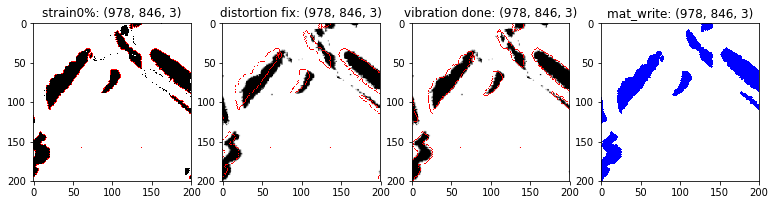

In [11]:
show_x = (200, 400); show_y = (400, 600)
plt.figure(figsize=(13,13))
plt.subplot(141),plt.imshow(cp_color[show_x[0]:show_x[1], show_y[0]:show_y[1]]),plt.title('strain0%: ' + str(cp_color.shape))
plt.subplot(142),plt.imshow(cp_color_strain4[show_x[0]:show_x[1], show_y[0]:show_y[1]]),plt.title('distortion fix: ' + str(cp_color_strain4.shape))
plt.subplot(143),plt.imshow(strain4_precise[show_x[0]:show_x[1], show_y[0]:show_y[1]]),plt.title('vibration done: ' + str(strain4_precise.shape))
plt.subplot(144),plt.imshow(mat_write[show_x[0]:show_x[1], show_y[0]:show_y[1]]),plt.title('mat_write: ' + str(mat_write.shape))
plt.show()

In [12]:
pd_size_strain4 = pd.DataFrame(size_strain4, columns=['size4'])
pd_size_strain4

,size4
0,215
1,552
2,407
3,255
4,222
5,194
6,361
7,196
8,385
9,730


In [13]:
pd_size_strain4 = pd_size_strain4*SCALE*SCALE
pd_size_strain4.to_csv(str(ROOT_DIR / 'output' / 'csv_files' / 'df_strain4_size.csv'), index=False)

**for comparison*

In [12]:
cv2.imwrite(str(ROOT_DIR / 'other' / 'mat_write_comparison.png'), mat_write)

True

In [13]:
# for comparison of contour
cv2.imwrite(str(ROOT_DIR / 'other' / 'strain4_precise.png'), cv2.cvtColor(strain4_precise, cv2.COLOR_RGB2BGR))

True